# Weight Decay Investigation
In this notebook, I'm going to attempt to run some experiments to find out why the weight decay parameter needs to be so different between BCE and AUCM losses. 

In [1]:
# imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

%load_ext autoreload
%autoreload 2

import torch
import torch.nn as nn
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

from torchvision.transforms import RandomHorizontalFlip, RandomResizedCrop, ToTensor, Normalize
from torchvision.transforms.functional import InterpolationMode

from dataloader import ChexpertDensenetDataloader, COMPETITION_TASKS

from sklearn.model_selection import train_test_split

from libauc.losses import AUCM_MultiLabel
from libauc.optimizers import PESG

import pickle

In [2]:
from weight_decay_eval import WeightDecayEvalTrainer

In [3]:
TRAIN_SPLIT = 0.8
BATCH_SIZE = 48
LEARNING_RATE = 1.5e-3
LR_SCHEDULER_TYPE = "cosine"
HIGH_WEIGHT_DECAY = 0.05
LOW_WEIGHT_DECAY = 1e-5
WARMUP_RATIO = 0.05
LOGGING_STRATEGY = "steps"
LOGGING_STEPS = 10
FP16 = True
EPOCHS = 1
EVALUATION_STRATEGY = "epoch"
EVAL_STEPS = 200
OUTPUT_DIR = './dense-net-weight-decay-1'
REMOVE_UNUSED_COLUMNS = False
GRAD_ACCUM_STEPS = 5
DATALOADER_NUM_WORKERS = 4
SAVE_TOTAL_LIMIT = 3
IMAGE_SIZE = 224

In [4]:
transforms = [
    RandomResizedCrop(IMAGE_SIZE, scale=(0.2, 1.0), interpolation=InterpolationMode.BICUBIC),
    RandomHorizontalFlip(),
    ToTensor(),
    Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
]

In [5]:
np.random.seed(42)
train_df = pd.read_csv("ChexPert/train.csv")
train_df, eval_df = train_test_split(train_df, train_size=TRAIN_SPLIT)

train_dataset_loader = ChexpertDensenetDataloader("ChexPert/data", train_df, transforms=transforms, classes=COMPETITION_TASKS,
    uncertainty_method="smooth", smoothing_lower_bound=0.55, smoothing_upper_bound=0.85)
eval_dataset_loader = ChexpertDensenetDataloader("ChexPert/data", eval_df, classes=COMPETITION_TASKS,
    uncertainty_method="smooth", smoothing_lower_bound=0.55, smoothing_upper_bound=0.85)

In [6]:
MAX_TRAINING_STEPS = 2500

In [8]:
model = torch.hub.load('pytorch/vision:v0.10.0', 'densenet121', pretrained=True)
model.features.conv0

Using cache found in /home/computernerdforlife49/.cache/torch/hub/pytorch_vision_v0.10.0


Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)

In [9]:
model = torch.hub.load('pytorch/vision:v0.10.0', 'densenet121', pretrained=True)
model.classifier = nn.Linear(1024, len(COMPETITION_TASKS))
model = model.to(device)

# set up for BCE weight decay
high_wd_bce_trainer = WeightDecayEvalTrainer()

criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=LEARNING_RATE, weight_decay=HIGH_WEIGHT_DECAY)

high_wd_bce_trainer.train(
    model,
    model.features.conv0,
    criterion,
    optimizer,
    train_dataset_loader,
    max_training_steps=MAX_TRAINING_STEPS,
)

with open("high_wd_bce.pickle", "wb") as f:
    pickle.dump(high_wd_bce_trainer.gradient_tracking, f)

Using cache found in /home/computernerdforlife49/.cache/torch/hub/pytorch_vision_v0.10.0
Epoch 0:   2%|▏         | 2500/152878 [03:18<3:19:20, 12.57batch/s, loss=0.58] 


In [16]:
auc_model = torch.hub.load('pytorch/vision:v0.10.0', 'densenet121', pretrained=True)
auc_model.classifier = nn.Linear(1024, len(COMPETITION_TASKS))
auc_model = auc_model.to(device)

high_wd_auc_trainer = WeightDecayEvalTrainer()

imratio = [
    0.1497333982353369,
    0.12095831165270714,
    0.0663119436471569,
    0.2344081328924473,
    0.3860606162333339
]
margin=1.0
gamma = 500

criterion = AUCM_MultiLabel(imratio=imratio, num_classes=len(imratio), margin=margin)
optimizer =  PESG(
    auc_model,
    a=criterion.a,
    b=criterion.b,
    alpha=criterion.alpha,
    lr=1.5e-2,
    gamma=gamma,
    margin=margin,
    weight_decay=HIGH_WEIGHT_DECAY
)

high_wd_auc_trainer.train(
    auc_model,
    auc_model.features.conv0,
    criterion,
    optimizer,
    train_dataset_loader,
    max_training_steps=MAX_TRAINING_STEPS,
)

with open("high_wd_auc.pickle", "wb") as f:
    pickle.dump(high_wd_auc_trainer.gradient_tracking, f)

Using cache found in /home/computernerdforlife49/.cache/torch/hub/pytorch_vision_v0.10.0
Epoch 0:   2%|▏         | 2500/152878 [03:28<3:28:43, 12.01batch/s, loss=1.37]   


In [12]:
model = torch.hub.load('pytorch/vision:v0.10.0', 'densenet121', pretrained=True)
model.classifier = nn.Linear(1024, len(COMPETITION_TASKS))
model = model.to(device)

low_wd_bce_trainer = WeightDecayEvalTrainer()

weight_decay = 1

criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=LEARNING_RATE, weight_decay=LOW_WEIGHT_DECAY)

low_wd_bce_trainer.train(
    model,
    model.features.conv0,
    criterion,
    optimizer,
    train_dataset_loader,
    max_training_steps=MAX_TRAINING_STEPS,
)

with open("low_wd_bce.pickle", "wb") as f:
    pickle.dump(low_wd_bce_trainer.gradient_tracking, f)

Using cache found in /home/computernerdforlife49/.cache/torch/hub/pytorch_vision_v0.10.0
Epoch 0:   2%|▏         | 2500/152878 [03:14<3:15:25, 12.83batch/s, loss=0.591]


In [17]:
auc_model = torch.hub.load('pytorch/vision:v0.10.0', 'densenet121', pretrained=True)
auc_model.classifier = nn.Linear(1024, len(COMPETITION_TASKS))
auc_model = auc_model.to(device)

low_wd_auc_trainer = WeightDecayEvalTrainer()

imratio = [
    0.1497333982353369,
    0.12095831165270714,
    0.0663119436471569,
    0.2344081328924473,
    0.3860606162333339
]
margin=1.0
gamma = 500

criterion = AUCM_MultiLabel(imratio=imratio, num_classes=len(imratio), margin=margin)
optimizer =  PESG(
    auc_model,
    a=criterion.a,
    b=criterion.b,
    alpha=criterion.alpha,
    lr=1.5e-2,
    gamma=gamma,
    margin=margin,
    weight_decay=LOW_WEIGHT_DECAY
)

low_wd_auc_trainer.train(
    auc_model,
    auc_model.features.conv0,
    criterion,
    optimizer,
    train_dataset_loader,
    max_training_steps=MAX_TRAINING_STEPS,
)

with open("low_wd_auc.pickle", "wb") as f:
    pickle.dump(low_wd_auc_trainer.gradient_tracking, f)

Using cache found in /home/computernerdforlife49/.cache/torch/hub/pytorch_vision_v0.10.0
Epoch 0:   2%|▏         | 2500/152878 [03:18<3:19:15, 12.58batch/s, loss=3.17]  


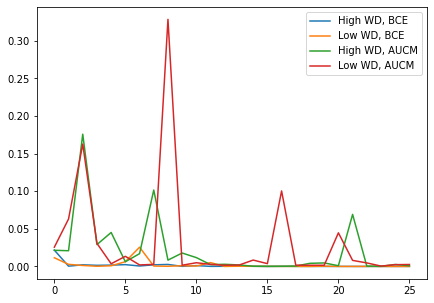

In [18]:
fig = plt.figure(figsize=(7,5))
fig.patch.set_facecolor("white")

with open("high_wd_bce.pickle", "rb") as f:
    high_wd_bce = pickle.load(f)

with open("high_wd_auc.pickle", "rb") as f:
    high_wd_auc = pickle.load(f)

with open("low_wd_bce.pickle", "rb") as f:
    low_wd_bce = pickle.load(f)

with open("low_wd_auc.pickle", "rb") as f:
    low_wd_auc = pickle.load(f)

plt.plot(list(range(len(high_wd_bce))), high_wd_bce, label="High WD, BCE")
plt.plot(list(range(len(low_wd_bce))), low_wd_bce, label="Low WD, BCE")
plt.plot(list(range(len(high_wd_auc))), high_wd_auc, label="High WD, AUCM")
plt.plot(list(range(len(low_wd_auc))), low_wd_auc, label="Low WD, AUCM")
plt.legend()